# Slice の情報を表示する

In [21]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import time
import nibabel as nib
import ctvis
from glob import glob
from pathlib import Path
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


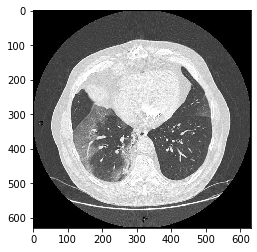

In [22]:
df = ctvis.get_df_all('../public-covid-data')
index = 0
volume = ctvis.load_nifti(df.iloc[index]['FilePathImage'])
mask = ctvis.load_nifti(df.iloc[index]['FilePathMask'])
mask_color = ctvis.label_color(mask)
volume_gray = ctvis.hu_to_gray(volume)
plt.imshow(volume_gray[:, :, 30])

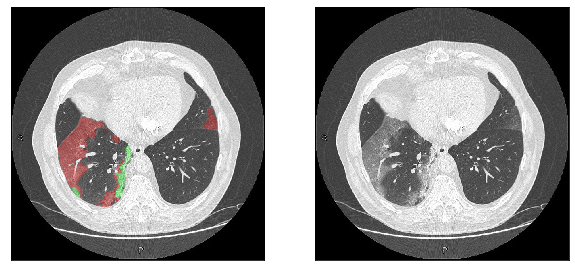

In [23]:
overlayed = ctvis.overlay(volume_gray, mask, mask_color, alpha=0.3)
data = [overlayed[:, :, 30], volume_gray[:, :, 30]]
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for idx, i in enumerate(data):
    axes[idx].imshow(i, cmap='gray')
    axes[idx].set_xticks(ticks=[])  # 横軸のメモリを消す
    axes[idx].set_yticks(ticks=[])  # 縦軸のメモリを消す

## 各種の情報を plot
1. **slice番号(index)を表示**
2. **各labelのHUの統計量を表示**
3. **軸を削除**

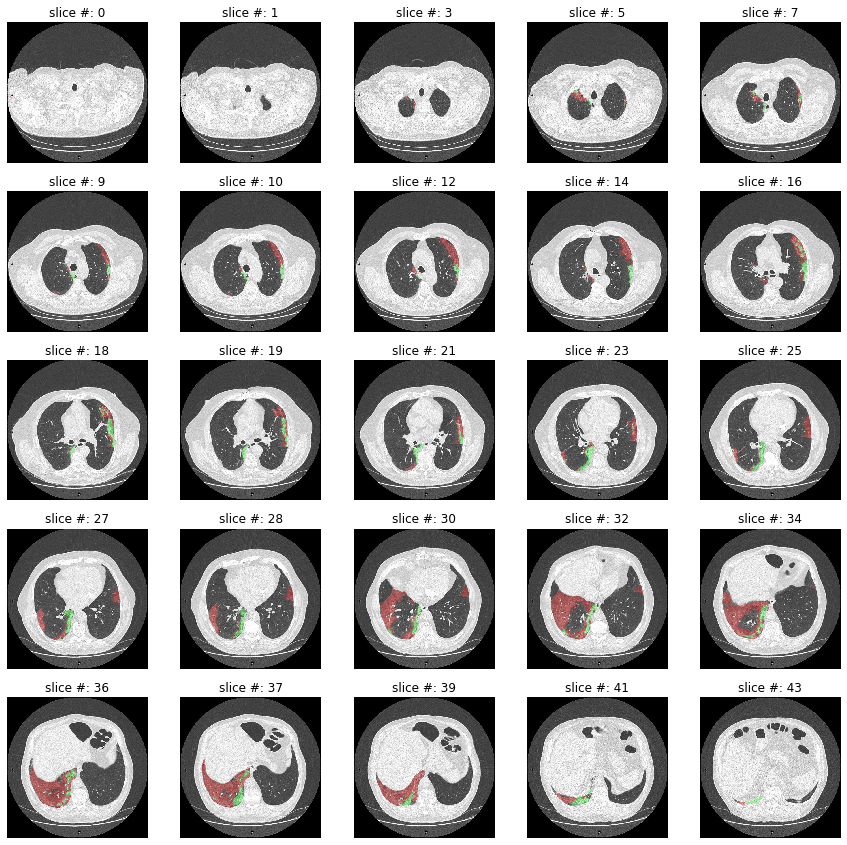

In [24]:
cols = 5
# rows = 5
display_num = 25                      # 何枚表示させるか
rows = (display_num - 1) // cols + 1  # 行 = (25枚表示　-1)//5 + 1 / -1 をする事により割きれて行が増える事を防止
total_num = overlayed.shape[-2]       # トータルの枚数 : (630, 630, 45, 3)
interval = total_num / display_num    # 等間隔にする : 100 / 10 = 10　飛ばし飛ばし
if interval < 1:                      # もしトータルより表示枚数が多くても、１が入るので必ず次の枚数を取得できる
    interval = 1

# 画像表示
figsize = (15, 15)
fig, ax = plt.subplots(rows, cols, figsize=figsize)
for i in range(display_num):          # トータルの枚数
    
    # 変数にしてしまう
    row_i = i//cols                   # 商
    col_i = i%cols                    # 余り  
    idx = int((i * interval))         # interval を計算した後に　intに変換
    if idx >= total_num:              # index は 0 から始まるので　＞＝　にする
        break                         # error ハンドリング　トータル枚数になったら　for文を抜ける
    
#     ax[i//cols, i%cols].imshow(overlayed[:, :, 10])　変数に置き換える
    ax[row_i, col_i].imshow(overlayed[:, :, idx])
    ax[row_i, col_i].set_title('slice #: {}'.format(idx))      # 各種 tilte 表示
    ax[row_i, col_i].axis('off')                               # 軸を非表示にできる

## HU の統計量を返す関数

In [25]:
mask.shape

(630, 630, 45)

In [26]:
volume.shape

(630, 630, 45)

In [27]:
# np.where(mask == 1, True, False)
# 上記をもっとシンプルに記述できる　：　やっている内容は同じ　/ pix の値が　１の所だけ True, それ以外を　False
np.equal(mask, 1)

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [28]:
# CT data に filter を掛ける
filter_ = np.equal(mask, 1)
volume[filter_]

array([-706.2600708 , -795.63824463, -706.2600708 , ..., -559.41223145,
       -565.80255127, -476.42437744])

In [29]:
# roi: region of interest / 平均と標準偏差を取得する
roi_hu = volume[filter_]
ggo_mean = np.mean(roi_hu)      # 平均値
ggo_std = np.std(roi_hu)        # 標準偏差
print(ggo_mean)
print(ggo_std)

-553.040983965225
171.02280861310823


- CT では　-1000が空気なので　＝　黒, 空気よりx線を通してない事になる


### <u>COVID-19</u>
- *アノテーションマスク*
    - **青　:　ground-glass ( mask valu = 1 )**
        - すりガラスみたいに少し白いモヤが罹った場所が病変箇所
        - 本来空気が入っている場所だが、少し液状化が進んでいる
    - **黄　:　consolidation ( = 2 )**
        - もっと水に浸って白くなっている状態
    - **緑　:　pleural effusion ( = 3 )**
        - pleural effusion( 胸水 )
        - 胸水　:　肺の膜と肺が入っている壁の間に水が溜まっている状態

#### for分の前に空の　dctionary　に　for分の中の　data をどんどん入れていく
- <u>非常に頻繁に使用するので必ず覚える</u>

In [30]:
# 上記の code をまとめる
mask
volume

# label　の dictionary を作成　/ key : value
label_dict = {1: 'ggo', 2: 'consolidation', 3: 'effusion'}

# 保存しておく用の　dictionary
result = {}

# .keys() : key の値を返してくれる
for label in label_dict.keys():
    prefix = label_dict[label]             # dictionary から　key　を指定して　値(value)を取得
    roi_hu = volume[np.equal(mask, label)]
    result[prefix + '_mean'] = np.mean(roi_hu) 
    result[prefix + '_std'] = np.std(roi_hu) 
    
    
# roi_hu = volume[np.equal(mask, 1)]
# ggo_mean = np.mean(roi_hu) 
# ggo_std = np.std(roi_hu)

# roi_hu = volume[np.equal(mask, 2)]
# consoli_mean = np.mean(roi_hu) 
# consoli_std = np.std(roi_hu)

# roi_hu = volume[np.equal(mask, 3)]
# effusion_mean = np.mean(roi_hu) 
# effusion_std = np.std(roi_hu)

In [31]:
result

{'ggo_mean': -553.040983965225,
 'ggo_std': 171.02280861310823,
 'consolidation_mean': -201.4915341831564,
 'consolidation_std': 227.0837774774284,
 'effusion_mean': nan,
 'effusion_std': nan}

In [32]:
title_ = 'slice # 3'
title_ += '\nggo_mean: 30±15'
title_ += '\nconsoli_mean: 30±15'
print(title_)

slice # 3
ggo_mean: 30±15
consoli_mean: 30±15


## scriptで表示できるかTestする

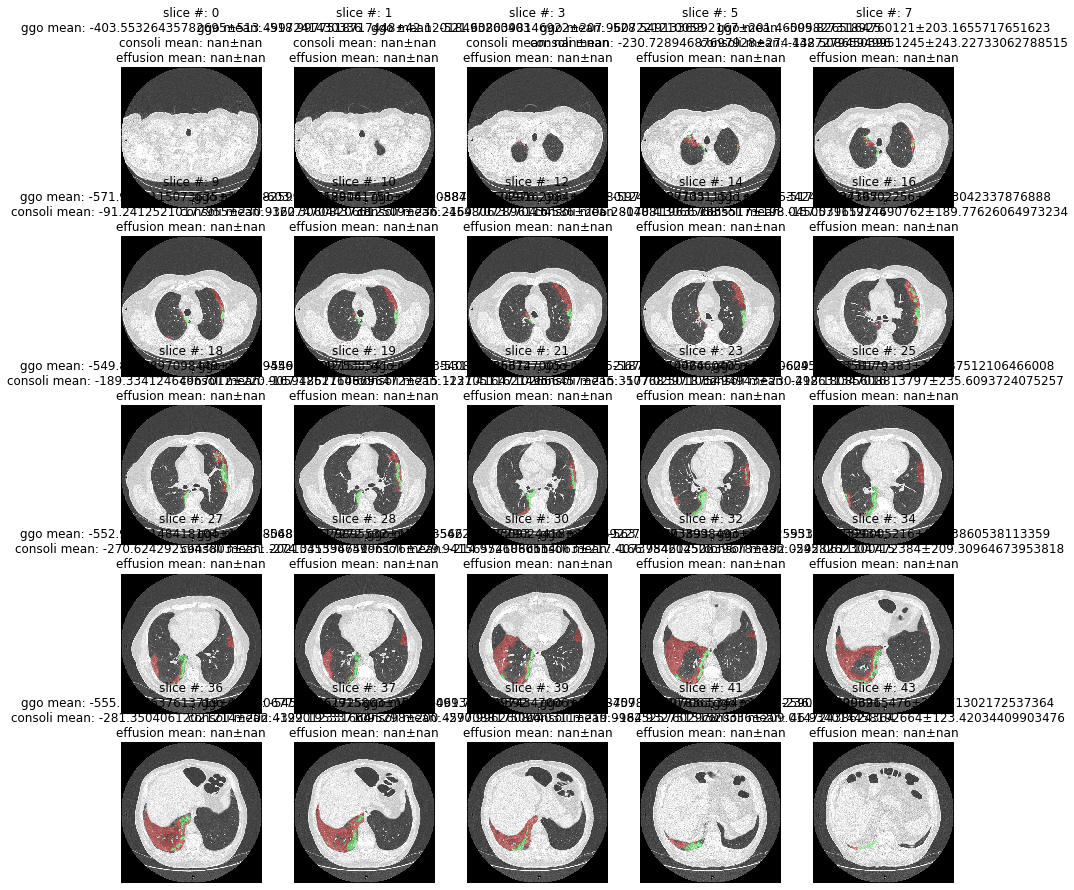

In [34]:
ctvis.vis_overlay(overlayed, volume, mask, cols=5, display_num=25)

### 小数点以下を修正・表示を修正

In [35]:
print('{}'.format(3.1234567))

3.1234567


In [36]:
print('{:.2f}'.format(3.1234567))

3.12


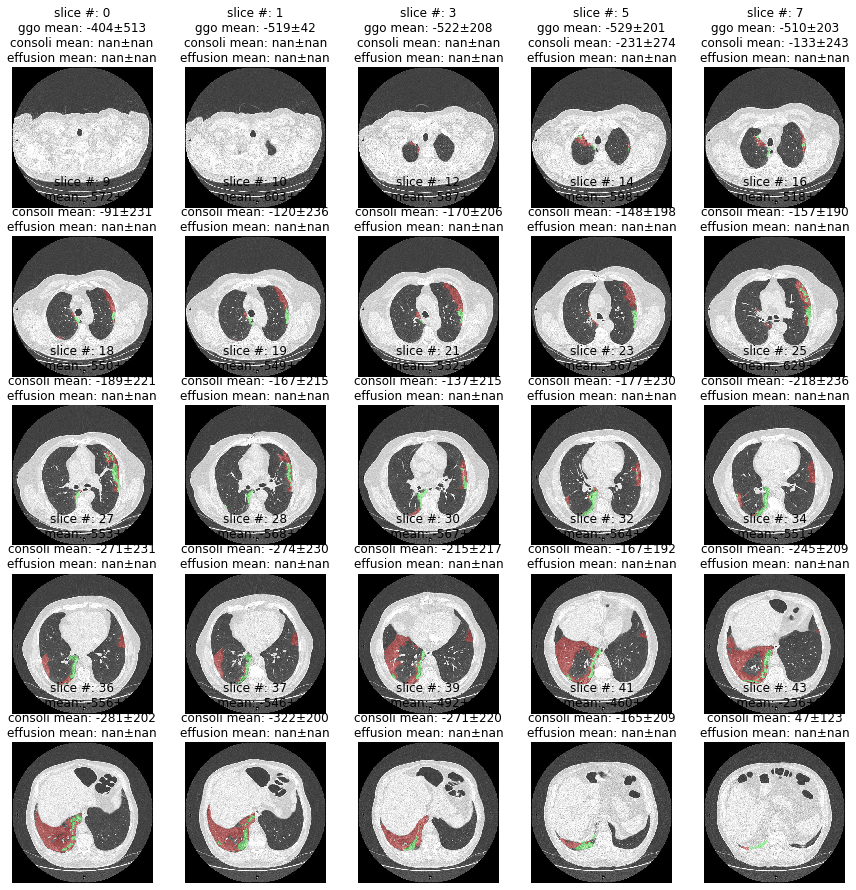

In [37]:
ctvis.vis_overlay(overlayed, volume, mask, cols=5, display_num=25)

### fig.tight_layout() を適用

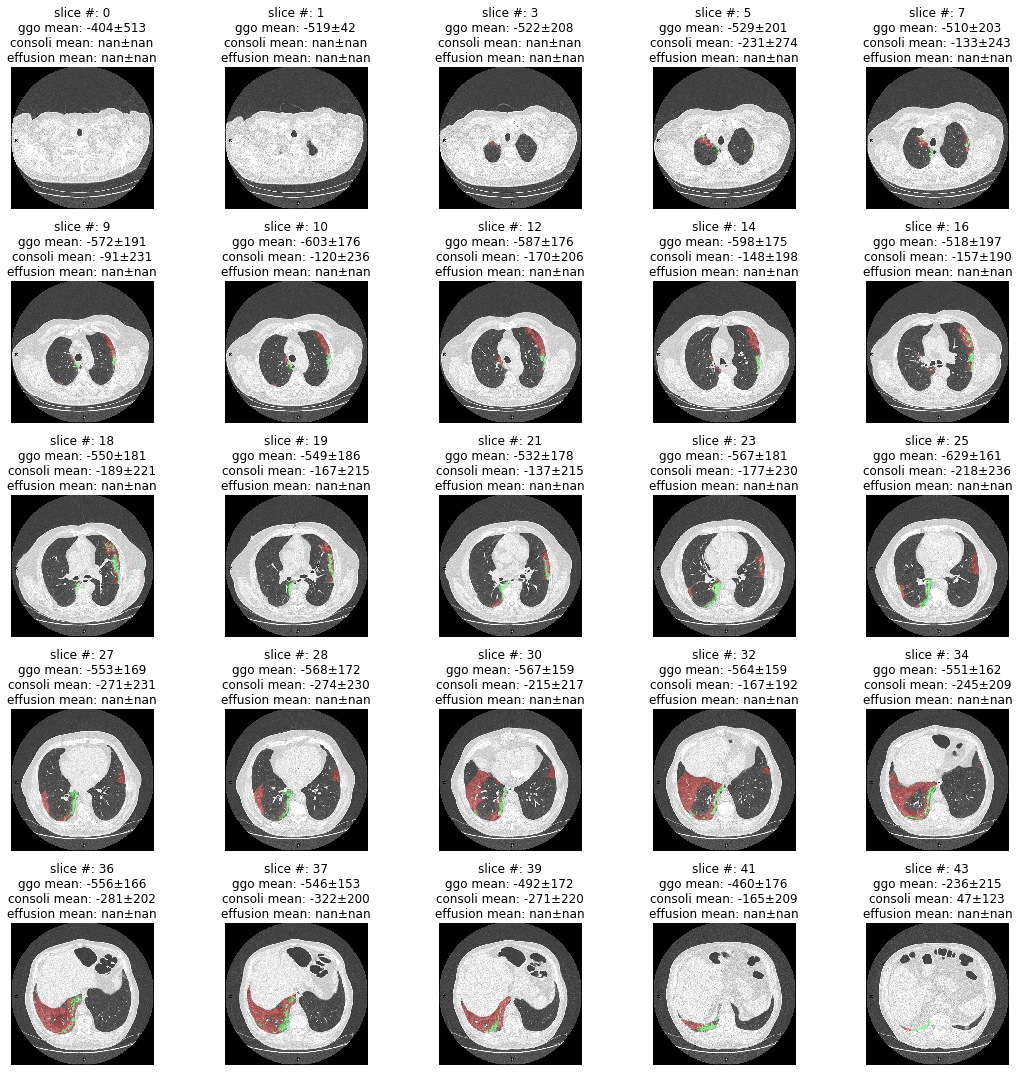

In [38]:
ctvis.vis_overlay(overlayed, volume, mask, cols=5, display_num=25)